In [9]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
test_databases = OpXRD.load_project_list(root_dirpath=smoltest_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-19 23:28:06]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-19 23:28:07]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC
[2024-12-19 23:28:07]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-19 23:28:07]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS


100% (210 of 210) |######################| Elapsed Time: 0:00:00 Time:  0:00:000000


[2024-12-19 23:28:08]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS
[2024-12-19 23:28:08]: Successfully extracted 210 patterns from 210/210 xrd files


In [10]:
from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=test_databases, output_dirpath='/tmp/opxrd_analysis')
#analyser.plot_in_single(limit_patterns=10)


In [11]:
#analyser.plot_fourier()

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 50

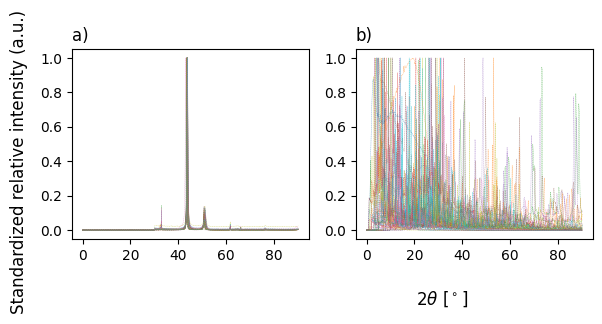

In [12]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 1000

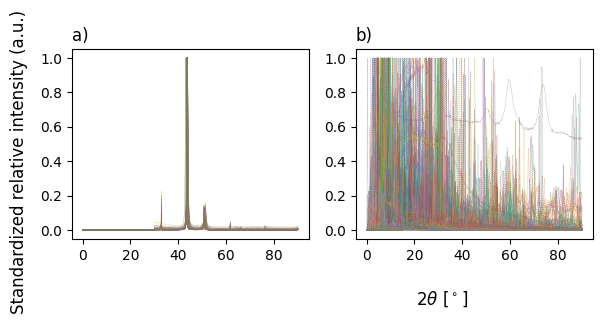

In [13]:
analyser.plot_in_single(limit_patterns=1000)

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 210


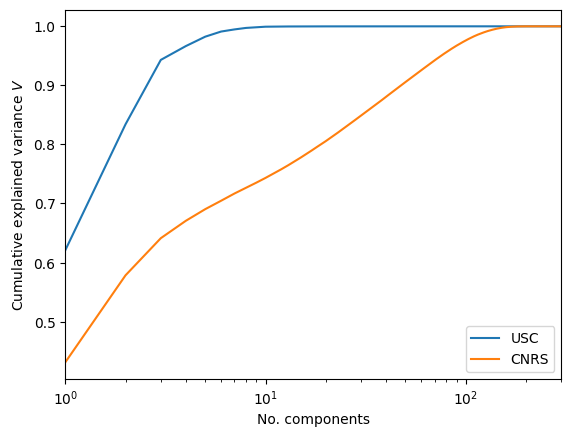

In [14]:
analyser.plot_effective_components()

---> Histogram of general information on opXRD

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


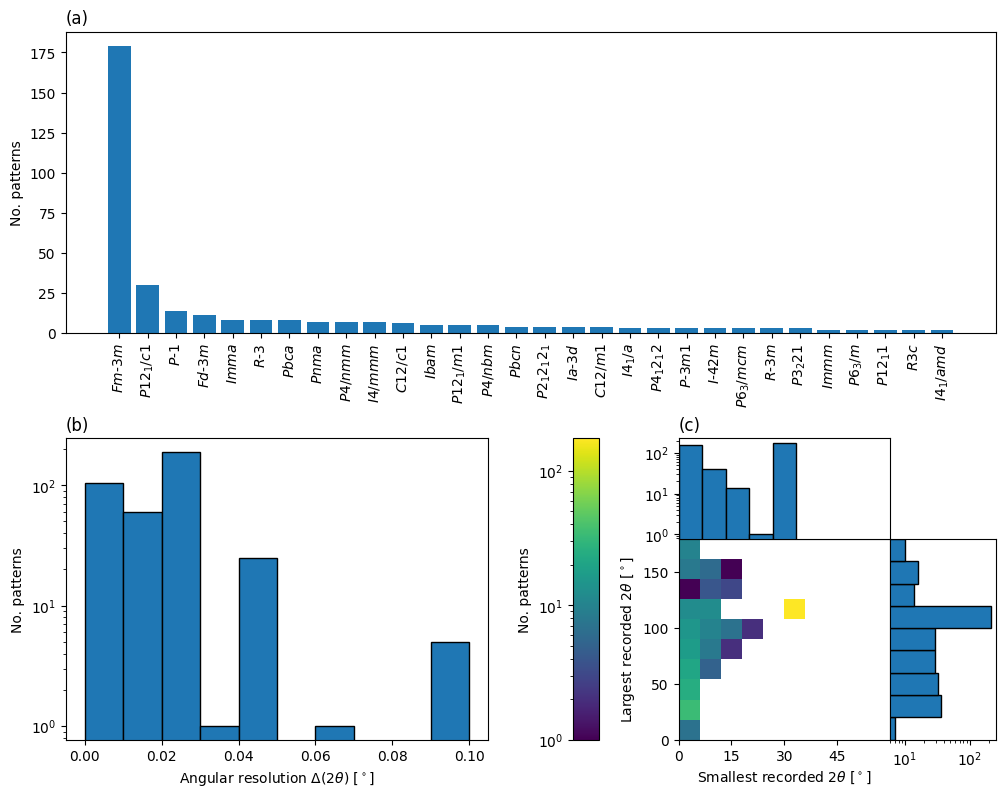

In [15]:
analyser.plot_histogram()

In [16]:
# analyser.show_label_fractions()
analyser.print_total_counts()

---> Total pattern counts in opXRD

Total number of patterns = 384
Number of labeled patterns = 384
